In [15]:

from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Input, Embedding, GRU, Flatten
from tensorflow.keras import Model

import time
import numpy as np
import sys
import io
import os
import codecs
import random
import json
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# URLs

In [4]:
sutras_fp = str(os.getcwd()) + r'\datasets\Sutras\Sutras_full.txt'
vedas_fp = str(os.getcwd()) + r'\datasets\Vedas\vedas.txt'
quran_fp = str(os.getcwd()) + r'\datasets\Quran\quran.txt'
tanakh_fp = str(os.getcwd()) + r'\datasets\Tanakh\Pentateuch_full.txt'
bible_fp = str(os.getcwd()) + r'\datasets\Bible\bible.txt'
#religious_texts_fp = str(os.getcwd()) + r'\datasets\religious_texts'

In [5]:

SEQUENCE_LEN = 10
MIN_WORD_FREQUENCY = 5
STEP = 1
BATCH_SIZE = 512


In [6]:
class TextData():
    def __init__(self, corpus_file):
        self.text = None
        self.tokens = None
        self.token_freq = None
        self.clean_text = None
        """Takes a corpus filename, opens a utf-8 file, """

        with io.open(corpus_file, encoding='utf-8') as f:
            self.text = f.read().lower().replace('\n', ' \n ')
            self.text = self.text.replace('\t', '')

            print('Corpus length in characters:', len(self.text))     
        self.corpus_len = len(self.text)
        print('Loaded corpus...')

    
    def get_token_freq(self):
        # Calculate word frequency
        self.token_freq = {}
        for token in self.tokens:
            self.token_freq[token] =  self.token_freq.get(token, 0) + 1
        return self.token_freq
    
    def get_char_freq(self):
        # Calculate word frequency
        self.char_freq = {}
        for char in self.text:
            self.char_freq[char] =  self.char_freq.get(char, 0) + 1
        return self.char_freq

    
    def tokenize(self):
        self.tokens = [w for w in self.text.split(' ') if w.strip() != '' or w == '\n']
        print('Corpus length in words:', len(self.tokens))
        return self.tokens
    


    

In [7]:
def drop_chars(txt):
    #return re.sub('[^A-Za-z0-9.,?!" -–]+', '', txt)
    return re.sub('[^A-Za-z0-9 ]+', '', txt)

In [8]:
def get_ignorable_words(word_freq):
    ignored_words = set()
    for k, v in word_freq.items():
        if word_freq[k] < MIN_WORD_FREQUENCY:
            ignored_words.add(k)
    return ignored_words


def get_words(text_in_words, ignored_words):
    words = set(text_in_words)
    print('Unique words before ignoring:', len(words))
    print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
    words = sorted(set(words) - ignored_words)
    print('Unique words after ignoring:', len(words))
    return words

In [9]:

def get_translate_dicts(words):
    word_indices = dict((c, i) for i, c in enumerate(words))
    indices_word = dict((i, c) for i, c in enumerate(words))
    return word_indices, indices_word


def get_training_data(text_in_words, ignored_words):
    # cut the text in semi-redundant sequences of SEQUENCE_LEN words
    sentences = []
    next_words = []
    ignored = 0
    for i in range(0, len(text_in_words) - SEQUENCE_LEN, STEP):
        # Only add the sequences where no word is in ignored_words
        if len(set(text_in_words[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
            sentences.append(text_in_words[i: i + SEQUENCE_LEN])
            next_words.append(text_in_words[i + SEQUENCE_LEN])
        else:
            ignored = ignored + 1
    print('Ignored sequences:', ignored)
    print('Remaining sequences:', len(sentences))
    return sentences, next_words


def get_training_data_one_list(text_in_words, ignored_words):
    # cut the text in semi-redundant sequences of SEQUENCE_LEN words
    text = []
    ignored = 0
    for i in text_in_words:
        # Only add the sequences where no word is in ignored_words
        if i not in ignored_words:
            text.append(i)
        else:
            ignored = ignored + 1
    print('Ignored sequences:', ignored)
    print('Remaining sequences:', len(text))
    return text

In [10]:
def log_vocabulary(words_file_path, words_set):
    """Takes a filepath and a list, and creates a text file to log that word list"""
    words_file = codecs.open(words_file_path, 'w', encoding='utf8')
    for w in words_set:
        if w != "\n":
            words_file.write(w+"\n")
        else:
            words_file.write(w)
    words_file.close()

In [11]:
sutras = TextData(sutras_fp)
vedas = TextData(vedas_fp)
bible = TextData(bible_fp)
tanakh = TextData(tanakh_fp)
quran = TextData(quran_fp)

Corpus length in characters: 7915214
Loaded corpus...
Corpus length in characters: 3808286
Loaded corpus...
Corpus length in characters: 4552748
Loaded corpus...
Corpus length in characters: 869286
Loaded corpus...
Corpus length in characters: 764579
Loaded corpus...


# Sutras

1. Set up, preprocess, clean, and plot initial EDA

In [16]:

## First drop and replace some bad characters to make the analysis simpler and more effective
sutras.text = drop_chars(sutras.text)
#Get and count the frequency of each character after cleaning
sutras_char_freq = sutras.get_char_freq()

#Basically split into words (words are tokens here)
sutras_tokens = sutras.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
sutras_freq = sutras.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
sutras_ignored_words = get_ignorable_words(sutras_freq) #ignored words less than frequency
sutras_kept_words = get_words(sutras_tokens, sutras_ignored_words) #keep words


#Get translation tables for kept tokens
sutras_encoder, sutras_decoder = get_translate_dicts(sutras_kept_words) #get translation tables
print("Encoder Table:\n",list(sutras_encoder.items())[:10],"\nDecoder Table:\n", list(sutras_decoder.items())[:10])

#Get the frequency of each word after pruning
sutras_kept_freq = dict(zip(sutras_kept_words,[sutras_freq[value] for value in sutras_kept_words]))

Corpus length in words: 1318748
Unique words before ignoring: 28369
Ignoring words with frequency < 5
Unique words after ignoring: 10205
Encoder Table:
 [('1', 0), ('10', 1), ('100', 2), ('1000', 3), ('102', 4), ('103', 5), ('104', 6), ('106', 7), ('107', 8), ('108', 9)] 
Decoder Table:
 [(0, '1'), (1, '10'), (2, '100'), (3, '1000'), (4, '102'), (5, '103'), (6, '104'), (7, '106'), (8, '107'), (9, '108')]


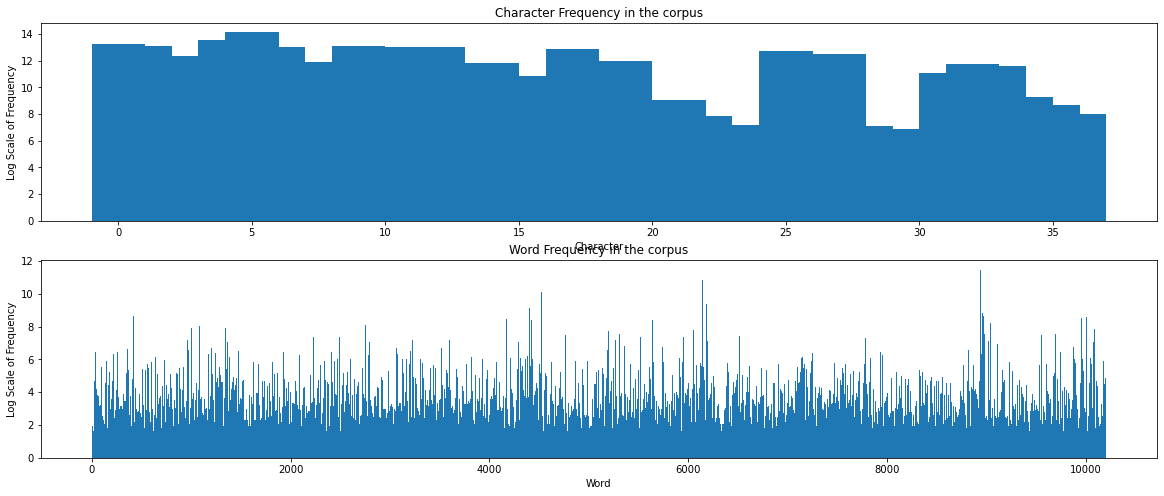

In [17]:
def plot_log_char_freq(char_freq, word_freq):
    df1 = pd.DataFrame(char_freq, index = [0])
    df2 = pd.DataFrame(word_freq, index = [0])
    fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (20,8));
   
    ax1.bar(range(len(df1.columns)),np.log(df1.iloc[0].values), width = 2);
    ax1.set_title('Character Frequency in the corpus');
    ax1.set_ylabel('Log Scale of Frequency');
    ax1.set_xlabel('Character');

    ax2.bar(range(len(df2.columns)),np.log(df2.iloc[0].values), width = 2);
    ax2.set_title('Word Frequency in the corpus');
    ax2.set_ylabel('Log Scale of Frequency');
    ax2.set_xlabel('Word');
    


In [ ]:
plot_log_char_freq(sutras_char_freq, sutras_kept_freq)


# Vedas

In [18]:

## First drop and replace some bad characters to make the analysis simpler and more effective
vedas.text = drop_chars(vedas.text)
#Get and count the frequency of each character after cleaning
vedas_char_freq = vedas.get_char_freq()

#Basically split into words (words are tokens here)
vedas_tokens = vedas.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
vedas_freq = vedas.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
vedas_ignored_words = get_ignorable_words(vedas_freq) #ignored words less than frequency
vedas_kept_words = get_words(vedas_tokens, vedas_ignored_words) #keep words


#Get translation tables for kept tokens
vedas_encoder, vedas_decoder = get_translate_dicts(vedas_kept_words) #get translation tables
print("Encoder Table:\n",list(vedas_encoder.items())[:10],"\nDecoder Table:\n", list(vedas_decoder.items())[:10])

#Get the frequency of each word after pruning
vedas_kept_freq = dict(zip(vedas_kept_words,[vedas_freq[value] for value in vedas_kept_words]))

Corpus length in words: 629129
Unique words before ignoring: 20324
Ignoring words with frequency < 5
Unique words after ignoring: 6016
Encoder Table:
 [('0', 0), ('1', 1), ('10', 2), ('1009', 3), ('1010', 4), ('1021', 5), ('1022', 6), ('1023', 7), ('1035', 8), ('1036', 9)] 
Decoder Table:
 [(0, '0'), (1, '1'), (2, '10'), (3, '1009'), (4, '1010'), (5, '1021'), (6, '1022'), (7, '1023'), (8, '1035'), (9, '1036')]


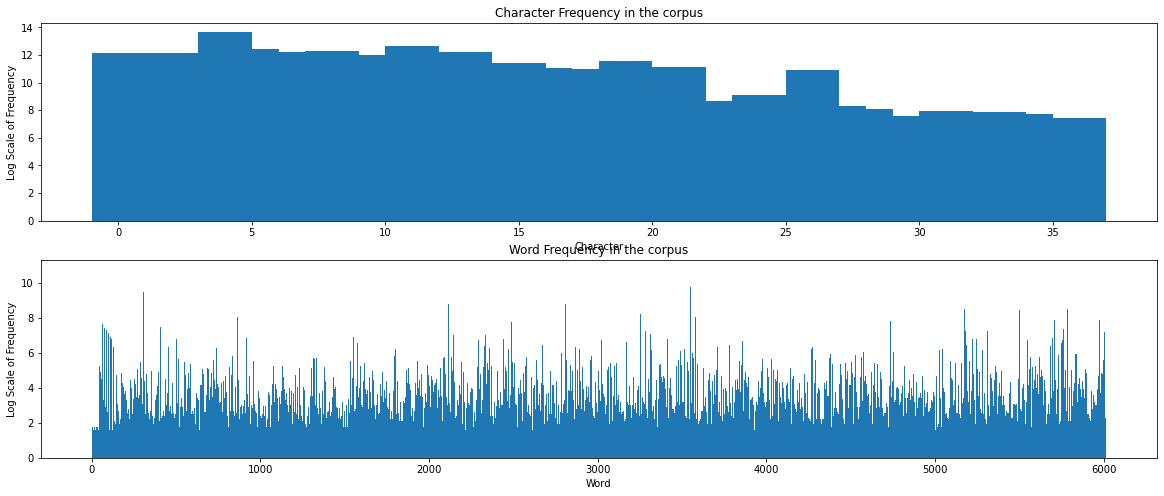

In [19]:
plot_log_char_freq(vedas_char_freq, vedas_kept_freq)


# Bible

In [20]:

## First drop and replace some bad characters to make the analysis simpler and more effective
bible.text = drop_chars(bible.text)
#Get and count the frequency of each character after cleaning
bible_char_freq = bible.get_char_freq()

#Basically split into words (words are tokens here)
bible_tokens = bible.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
bible_freq = bible.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
bible_ignored_words = get_ignorable_words(bible_freq) #ignored words less than frequency
bible_kept_words = get_words(bible_tokens, bible_ignored_words) #keep words


#Get translation tables for kept tokens
bible_encoder, bible_decoder = get_translate_dicts(bible_kept_words) #get translation tables
print("Encoder Table:\n",list(bible_encoder.items())[:10],"\nDecoder Table:\n", list(bible_decoder.items())[:10])

#Get the frequency of each word after pruning
bible_kept_freq = dict(zip(bible_kept_words,[bible_freq[value] for value in bible_kept_words]))

Corpus length in words: 824172
Unique words before ignoring: 16948
Ignoring words with frequency < 5
Unique words after ignoring: 6829
Encoder Table:
 [('101', 0), ('1010', 1), ('1011', 2), ('1012', 3), ('1013', 4), ('1014', 5), ('1015', 6), ('1016', 7), ('1017', 8), ('1018', 9)] 
Decoder Table:
 [(0, '101'), (1, '1010'), (2, '1011'), (3, '1012'), (4, '1013'), (5, '1014'), (6, '1015'), (7, '1016'), (8, '1017'), (9, '1018')]


In [ ]:
plot_log_char_freq(bible_char_freq, bible_kept_freq)


# Tanakh

In [21]:

## First drop and replace some bad characters to make the analysis simpler and more effective
tanakh.text = drop_chars(tanakh.text)
#Get and count the frequency of each character after cleaning
tanakh_char_freq = tanakh.get_char_freq()

#Basically split into words (words are tokens here)
tanakh_tokens = tanakh.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
tanakh_freq = tanakh.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
tanakh_ignored_words = get_ignorable_words(tanakh_freq) #ignored words less than frequency
tanakh_kept_words = get_words(tanakh_tokens, tanakh_ignored_words) #keep words


#Get translation tables for kept tokens
tanakh_encoder, tanakh_decoder = get_translate_dicts(tanakh_kept_words) #get translation tables
print("Encoder Table:\n",list(tanakh_encoder.items())[:10],"\nDecoder Table:\n", list(tanakh_decoder.items())[:10])

#Get the frequency of each word after pruning
tanakh_kept_freq = dict(zip(tanakh_kept_words,[tanakh_freq[value] for value in tanakh_kept_words]))

Corpus length in words: 162580
Unique words before ignoring: 6789
Ignoring words with frequency < 5
Unique words after ignoring: 2397
Encoder Table:
 [('101', 0), ('1010', 1), ('1011', 2), ('1012', 3), ('1013', 4), ('1014', 5), ('1015', 6), ('1016', 7), ('1017', 8), ('1018', 9)] 
Decoder Table:
 [(0, '101'), (1, '1010'), (2, '1011'), (3, '1012'), (4, '1013'), (5, '1014'), (6, '1015'), (7, '1016'), (8, '1017'), (9, '1018')]


In [ ]:
plot_log_char_freq(tanakh_char_freq, tanakh_kept_freq)


# Quran

In [22]:

## First drop and replace some bad characters to make the analysis simpler and more effective
quran.text = drop_chars(quran.text)
#Get and count the frequency of each character after cleaning
quran_char_freq = quran.get_char_freq()

#Basically split into words (words are tokens here)
quran_tokens = quran.tokenize() # tokens
#Get and count the freq of each word/token PRE IGNORED WORDS
quran_freq = quran.get_token_freq() # freq

#Get ignorable words less than the global var min word frequency
quran_ignored_words = get_ignorable_words(quran_freq) #ignored words less than frequency
quran_kept_words = get_words(quran_tokens, quran_ignored_words) #keep words


#Get translation tables for kept tokens
quran_encoder, quran_decoder = get_translate_dicts(quran_kept_words) #get translation tables
print("Encoder Table:\n",list(quran_encoder.items())[:10],"\nDecoder Table:\n", list(quran_decoder.items())[:10])

#Get the frequency of each word after pruning
quran_kept_freq = dict(zip(quran_kept_words,[quran_freq[value] for value in quran_kept_words]))

Corpus length in words: 139057
Unique words before ignoring: 6962
Ignoring words with frequency < 5
Unique words after ignoring: 1981
Encoder Table:
 [('a', 0), ('aad', 1), ('aaron', 2), ('abandon', 3), ('abide', 4), ('abiding', 5), ('able', 6), ('abode', 7), ('about', 8), ('above', 9)] 
Decoder Table:
 [(0, 'a'), (1, 'aad'), (2, 'aaron'), (3, 'abandon'), (4, 'abide'), (5, 'abiding'), (6, 'able'), (7, 'abode'), (8, 'about'), (9, 'above')]


In [ ]:
plot_log_char_freq(quran_char_freq, quran_kept_freq)


#  Encode

## Sutras

In [23]:
sutras_sentences, sutras_next_words = get_training_data(sutras_tokens, sutras_ignored_words)

#Set up the full encoded training list
sutras_encoded = []

#Update the list with the encoded values
for seq in sutras_sentences:
    int_sutras_encode = []
    for v in seq:
        int_sutras_encode.append(sutras_encoder[v])
    sutras_encoded.append(int_sutras_encode)


Ignored sequences: 236873
Remaining sequences: 1081865


In [24]:
sutras_t = get_training_data_one_list(sutras_tokens, sutras_ignored_words)
print('Original Text in Words Length: ',len(sutras_tokens))
print('After Ignored Words Text in Words Length: ',len(sutras_t))

Ignored sequences: 30180
Remaining sequences: 1288568
Original Text in Words Length:  1318748
After Ignored Words Text in Words Length:  1288568


## Vedas

In [ ]:
vedas_sentences, vedas_next_words = get_training_data(vedas_tokens, vedas_ignored_words)

#Set up the full encoded training list
vedas_encoded = []

#Update the list with the encoded values
for seq in vedas_sentences:
    int_vedas_encode = []
    for v in seq:
        int_vedas_encode.append(vedas_encoder[v])
    vedas_encoded.append(int_vedas_encode)


In [25]:
vedas_t = get_training_data_one_list(vedas_tokens, vedas_ignored_words)
print('Original Text in Words Length: ',len(vedas_tokens))
print('After Ignored Words Text in Words Length: ',len(vedas_t))

Ignored sequences: 23711
Remaining sequences: 605418
Original Text in Words Length:  629129
After Ignored Words Text in Words Length:  605418


## Bible

In [ ]:
bible_sentences, bible_next_words = get_training_data(bible_tokens, bible_ignored_words)

#Set up the full encoded training list
bible_encoded = []

#Update the list with the encoded values
for seq in bible_sentences:
    int_bible_encode = []
    for v in seq:
        int_bible_encode.append(bible_encoder[v])
    bible_encoded.append(int_bible_encode)


In [26]:
bible_t = get_training_data_one_list(bible_tokens, bible_ignored_words)
print('Original Text in Words Length: ',len(bible_tokens))
print('After Ignored Words Text in Words Length: ',len(bible_t))

Ignored sequences: 17366
Remaining sequences: 806806
Original Text in Words Length:  824172
After Ignored Words Text in Words Length:  806806


## Tanakh

In [ ]:
tanakh_sentences, tanakh_next_words = get_training_data(tanakh_tokens, tanakh_ignored_words)

#Set up the full encoded training list
tanakh_encoded = []

#Update the list with the encoded values
for seq in tanakh_sentences:
    int_tanakh_encode = []
    for v in seq:
        int_tanakh_encode.append(tanakh_encoder[v])
    tanakh_encoded.append(int_tanakh_encode)


In [27]:
tanakh_t = get_training_data_one_list(tanakh_tokens, tanakh_ignored_words)
print('Original Text in Words Length: ',len(tanakh_tokens))
print('After Ignored Words Text in Words Length: ',len(tanakh_t))

Ignored sequences: 8047
Remaining sequences: 154533
Original Text in Words Length:  162580
After Ignored Words Text in Words Length:  154533


## Quran

In [ ]:
quran_sentences, quran_next_words = get_training_data(quran_tokens, quran_ignored_words)

#Set up the full encoded training list
quran_encoded = []

#Update the list with the encoded values
for seq in quran_sentences:
    int_quran_encode = []
    for v in seq:
        int_quran_encode.append(quran_encoder[v])
    quran_encoded.append(int_quran_encode)


In [28]:
quran_t = get_training_data_one_list(quran_tokens, quran_ignored_words)
print('Original Text in Words Length: ',len(quran_tokens))
print('After Ignored Words Text in Words Length: ',len(quran_t))

Ignored sequences: 8380
Remaining sequences: 130677
Original Text in Words Length:  139057
After Ignored Words Text in Words Length:  130677


In [29]:
quran_encoded_t = [quran_encoder[i] for i in quran_t]


# Embedding

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate
from tensorflow.keras.layers import Embedding, dot, Dot
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence

import urllib
import collections
import os
import zipfile

import numpy as np


# Quran Setup

In [57]:
#The size of each vocabulary of each text
vocab_size = len(quran_encoder)

In [69]:
window_size = 10
vector_dim = 300
epochs = 100000

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [59]:
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(quran_encoded_t, vocab_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[1491, 453], [1832, 1739], [1898, 826], [1755, 421], [1740, 256], [1912, 1612], [1091, 968], [1740, 1667], [1579, 524], [1747, 86]] [0, 0, 1, 1, 1, 0, 0, 0, 0, 1]


# Quran Modeling

In [70]:
import tensorflow.keras.backend as K
# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
#similarity = merge([target, context], mode='cos', dot_axes=0)
#similarity = Dot(axes = 1, normalize = True)([target, context])

# now perform the dot product operation to get a similarity measure
#dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Dot(axes = 1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

# create the primary training model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [71]:
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]
    loss = model.train_on_batch([arr_1, arr_2], arr_3)
    if cnt % 10000 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
#     if cnt % 8 == 0:
#         sim_cb.run_sim()

Iteration 0, loss=0.702477216720581
Iteration 10000, loss=0.6650941371917725
Iteration 20000, loss=0.6162722706794739
Iteration 30000, loss=0.6776574850082397
Iteration 40000, loss=0.7152571678161621
Iteration 50000, loss=0.6500452756881714
Iteration 60000, loss=0.7102140784263611
Iteration 70000, loss=0.7358720898628235
Iteration 80000, loss=0.690788745880127
Iteration 90000, loss=0.8171643018722534


In [62]:
model.layers

In [75]:

# merge_layer = model.layers[0]
# word_model = merge_layer.layers[0]
# word_embed_layer = word_model.layers[0]
weights = model.layers[2].get_weights()[0][:]

print(weights.shape)
pd.DataFrame(weights, index=quran_decoder.values()).head()

(1981, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
a,-0.045440,-0.026013,0.007654,-0.007973,0.044732,-0.006255,0.008879,0.013024,-0.009417,-0.006453,...,0.032584,-0.006197,0.003579,0.021110,-0.006904,-0.031211,-0.036980,-0.042266,-0.016543,0.049571
aad,0.013617,0.015056,-0.018383,0.000736,0.048581,-0.019784,-0.039316,-0.039542,0.067181,-0.009452,...,0.039012,0.060449,0.011087,-0.060688,-0.043350,-0.008990,-0.025304,-0.025456,-0.019287,-0.005289
aaron,0.056159,0.017947,0.035158,-0.039090,-0.019736,0.018471,0.014877,0.053986,-0.046747,-0.041504,...,0.025975,0.067471,0.005216,-0.055508,0.040220,-0.028374,0.047880,-0.058288,0.064695,0.013394
abandon,-0.064466,0.010181,0.030500,0.006692,0.015697,-0.007454,0.053093,0.004099,-0.014088,0.024240,...,-0.025527,0.052049,0.033741,0.047252,-0.035228,-0.027498,-0.020381,-0.029478,0.003847,-0.070075
abide,-0.047073,-0.040273,-0.007744,-0.020547,0.037795,0.028614,-0.012578,-0.005823,-0.027154,-0.020111,...,0.003519,-0.013574,-0.030284,-0.082902,0.057195,-0.009216,0.062273,-0.000249,-0.019753,0.006165


In [76]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [quran_decoder[idx] for idx in distance_matrix[quran_encoder[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['six', 'he', 'white', 'child']}

similar_words

(1981, 1981)


{'six': ['intercession', 'did', 'repents', 'joseph', 'utterly'],
 'he': ['closed', 'disappointed', 'invisible', 'majesty', 'repents'],
 'white': ['scream', 'nothing', 'scheme', 'adversity', 'being'],
 'child': ['hereafter', 'proclaim', 'spring', 'sick', 'magicians']}